# Collinearity and Bayesian Regression

A draft response to [this question on Reddit](https://www.reddit.com/r/statistics/comments/1gyg0t2/q_overfitting_in_a_least_squares_regression/).

This notebook is based on *Think Bayes 2e*, which is available from
[Bookshop.org](https://bookshop.org/a/98697/9781492089469) and
[Amazon](https://amzn.to/334eqGo).

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ThinkBayes2/blob/master/examples/dual_log.ipynb).

In [1]:
try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

In [2]:
# download utils.py

from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkBayes2/raw/master/soln/utils.py")

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils import decorate

plt.rcParams["figure.dpi"] = 75
plt.rcParams["figure.figsize"] = [6, 3.5]

The well-behaved dataset

In [5]:
data = {
    "t": [
        6.305,
        13.511,
        20.719,
        27.828,
        35.038,
        42.247,
        49.451,
        56.658,
        63.861,
        71.07,
        78.275,
        85.38,
        92.589,
        99.806,
        107.013,
        114.218,
        121.431,
        128.639,
        135.844,
        142.952,
    ],
    "y": [
        2.73463519e-14,
        3.85426599e-14,
        3.80828479e-14,
        3.16131129e-14,
        3.45657229e-14,
        4.07274529e-14,
        4.06697749e-14,
        4.87061129e-14,
        5.76658129e-14,
        5.52670029e-14,
        5.26504439e-14,
        4.84613229e-14,
        6.77128129e-14,
        5.81555409e-14,
        5.51561319e-14,
        6.93846929e-14,
        6.32508629e-14,
        5.86075490e-14,
        5.60123029e-14,
        6.57248479e-14,
    ],
}

df = pd.DataFrame(data)
df["y"] *= 1e15
df.head()

,t,y
0,6.305,27.346352
1,13.511,38.542660
2,20.719,38.082848
3,27.828,31.613113
4,35.038,34.565723


<IPython.core.display.Javascript object>

The problematic dataset, scaled so `y` is in fA.

In [6]:
data = {
    "t": [5.98, 13.183, 20.385, 27.592, 34.801, 41.907, 49.112, 56.323, 63.526, 70.73, 
          77.944, 85.152, 92.258, 99.464, 106.672, 113.878, 121.091, 128.299, 135.508, 142.713],
    "y": [5.03036152e-14, 5.56276292e-14, 5.32424602e-14, 3.89444756e-14, 4.69391602e-14,
              5.39758602e-14, 5.45844802e-14, 6.32446202e-14, 5.73647722e-14, 6.10179202e-14,
              6.95350302e-14, 7.45465402e-14, 6.81008702e-14, 7.72761312e-14, 8.76658102e-14,
              9.02147102e-14, 9.10902732e-14, 8.62184102e-14, 8.40578302e-14, 9.40117102e-14]
}

# Create the DataFrame
df = pd.DataFrame(data)
df['y'] *= 1e15
df.head()

,t,y
0,5.980,50.303615
1,13.183,55.627629
2,20.385,53.242460
3,27.592,38.944476
4,34.801,46.939160


<IPython.core.display.Javascript object>

Compute the explanatory variables.

In [34]:
df["t32"] = np.log(df["t"] + 32)
df["t30"] = np.log(df["t"] + 30)
df[["t30", "t32"]].corr()

,t30,t32
t30,1.000000,0.999985
t32,0.999985,1.000000


<IPython.core.display.Javascript object>

The explanatory variables are highly correlated, which is going to be a problem.

In [7]:
import statsmodels.formula.api as smf

model = smf.ols(formula="y ~ t32 + t30", data=df).fit()
df["pred"] = model.predict(df)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                     84.48
Date:                Mon, 25 Nov 2024   Prob (F-statistic):           1.47e-09
Time:                        09:51:01   Log-Likelihood:                -60.335
No. Observations:                  20   AIC:                             126.7
Df Residuals:                      17   BIC:                             129.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -413.8304     67.870     -6.097      0.000    -557.024    -270.637
t32         2469.9101    487.780      5.064      0.000    1440.784    3499.036
t30        -2376.6967    475.603     -4.997      0.000   -3380.132   -1373.262
==============================================================================
Omnibus:                        1.819   Durbin-Watson:                   1.759
Prob(Omnibus):                  0.403   Jarque-Bera (JB):                1.029
Skew:                          -0.149   Prob(JB):                        0.598
Kurtosis:                       1.929   Cond. No.                     3.75e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.75e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<IPython.core.display.Javascript object>

Sure enough, `ols` complains about the collinearity.

And here's what the fitted model looks like.

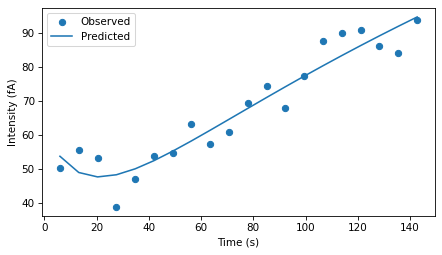

<IPython.core.display.Javascript object>

In [8]:
plt.scatter(df["t"], df["y"], label="Observed")
plt.plot(df["t"], df["pred"], label="Predicted")
decorate(xlabel="Time (s)")
decorate(ylabel="Intensity (fA)")

The up-swoop on the left is non-physical.

Let's see how Bayesian regression handles collinearity.

In [20]:
import pymc as pm
import arviz as az

with pm.Model() as model:
    # Priors for coefficients
    a = pm.Normal("a", mu=0, sigma=100)
    b = pm.Normal("b", mu=0, sigma=100)
    c = pm.Normal("c", mu=0, sigma=100)

    # Model equation
    mu = a * df["t32"] + b * df["t30"] + c

    # Observational noise
    sigma = pm.HalfNormal("sigma", sigma=100)

    # Likelihood
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=df["y"])

    # Sampling
    idata = pm.sample(500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, c, sigma]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 90 seconds.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.


<IPython.core.display.Javascript object>

The sampling process throws some divergences, which makes sense because the high-density part of the probability space is a long, narrow tunnel, so it's easy to spin out.

Nevertheless, the diagnostics look fine.

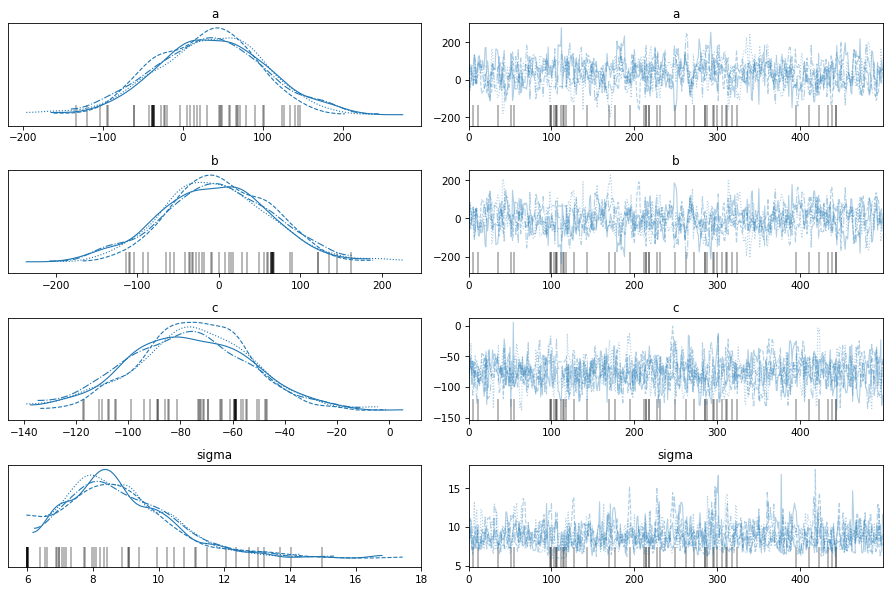

<IPython.core.display.Javascript object>

In [21]:
az.plot_trace(idata)
plt.tight_layout()

The `r_hat` values are fine.

The only notable problem is that the standard deviations are super big, but that's because the model borders on being non-identifiable.

In [22]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,33.297,69.111,-95.628,164.461,3.343,2.366,427.0,819.0,1.01
b,-1.840,67.288,-140.286,116.418,3.220,2.278,439.0,886.0,1.01
c,-76.071,22.673,-118.476,-33.281,0.872,0.617,678.0,927.0,1.01
sigma,8.858,1.614,5.981,11.687,0.059,0.041,671.0,305.0,1.01


<IPython.core.display.Javascript object>

To show what the issue is, let's look at the joint distribution of `a` and `b`.

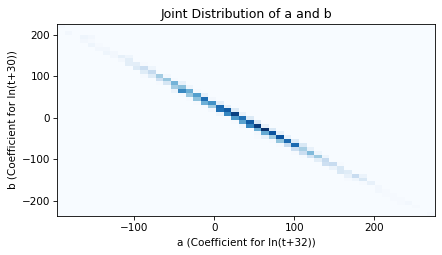

<IPython.core.display.Javascript object>

In [26]:
a_samples = idata.posterior["a"].values.flatten()
b_samples = idata.posterior["b"].values.flatten()
c_samples = idata.posterior["c"].values.flatten()

plt.hist2d(a_samples, b_samples, bins=50, cmap="Blues", density=True)
plt.xlabel("a (Coefficient for ln(t+32))")
plt.ylabel("b (Coefficient for ln(t+30))")
plt.title("Joint Distribution of a and b")
plt.tight_layout()

They are highly correlated, which indicates that we can't be confident about the actual values of `a` and `b`, but we can be confident about their sum -- and that's all we need.

Here's the posterior distribution of the sum, with a much more reasonable range of values.

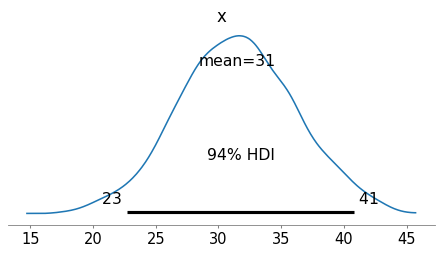

<IPython.core.display.Javascript object>

In [31]:
diff_samples = a_samples + b_samples
az.plot_posterior(diff_samples)
plt.tight_layout()

Instead of looking at the parameters, let's look at the predictions.
The following figure shows the model predictions for 50 of the samples.

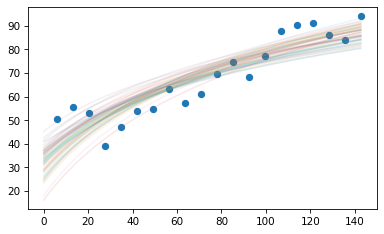

<IPython.core.display.Javascript object>

In [35]:
ts = np.linspace(0, df["t"].max())
ln_t_plus_32 = np.log(ts + 32)
ln_t_plus_30 = np.log(ts + 30)


plt.scatter(df["t"], df["y"], label="Observed Data")

n = len(a_samples)
for i in range(0, n, n // 50):
    y_pred = a_samples[i] * ln_t_plus_32 + b_samples[i] * ln_t_plus_30 + c_samples[i]
    plt.plot(ts, y_pred, alpha=0.1)

None of them have the non-physical upswoop.

We can use the sampled parameters to compute the distribution of the intercept at `t=0`.

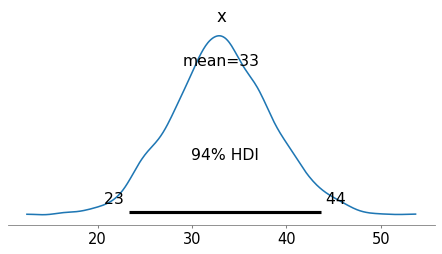

<IPython.core.display.Javascript object>

In [32]:
intercept_samples = a_samples * np.log(32) + b_samples * np.log(30) + c_samples

az.plot_posterior(intercept_samples)
plt.tight_layout()

Based on the experimental design and the data, that might be the best estimate we can make.

As an aside, since this model only has three parameters, we could use a grid algorithm to approximate the posterior distribution quickly and deterministically.

Copyright 2024 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)